## Setup and data read

In [1]:
# Imports and parameter setting
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as Funcs

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn import ensemble

import pandas as pd
import numpy as np
import cPickle as pickle

pd.set_option("display.max_columns", 100)

inputPath = '/home/jovyan/work/data/autot4.7.csv'

# Create a spark session
session = SparkSession \
    .builder \
    .appName("Car data") \
    .config('spark.driver.memory', '5G') \
    .config('spark.executor.memory', '5G') \
    .getOrCreate()
    


In [2]:
# Read input data into a spark data frame
# remove . from column names
inDf = session.read \
    .format("org.apache.spark.csv") \
    .option("header", "true") \
    .option("delimiter", ";") \
    .option("mode", "DROPMALFORMED") \
    .csv(inputPath)
    
newColnames = [col.replace('.','_',5) for col in inDf.columns]
inDf = inDf.toDF(*newColnames)

In [3]:
#Select a subset of columns and set their types 
carsDf = inDf.select(
    'ajoneuvoluokka',
    'ajoneuvonkaytto',
    'ajoneuvoryhma',
    'korityyppi',
    'ohjaamotyyppi',
    'kayttovoima',
    'istumapaikkojenLkm',
    'sylintereidenLkm',
    'vaihteisto',
    'alue',
    'kunta',
    'merkki',
    'malli',
    'merkki_l_malli',
    'kayttoonotto_pvm_imputoitu',
    inDf['omamassa'].cast("int"),
    inDf['iskutilavuus'].cast("int"),
    inDf['suurinNettoteho'].cast("int"),
    inDf['matkamittarilukema'].cast("int"),
    inDf['kayttoonottoVuosi'].cast("int"),
    inDf['ensirekVuosi'].cast("int"),
    inDf['ensirekisterointipvm'].cast("timestamp"),
    inDf['kayttoonottopvm'].cast("timestamp"),
    inDf['max_date'].cast("timestamp"),
    inDf['kayttoonotto'].cast("timestamp")
)
# List of variables by types strings are called 'factors'
factorVars = [
    'ajoneuvoluokka',
    'ajoneuvonkaytto',
    'ajoneuvoryhma',
    'korityyppi',
    'ohjaamotyyppi',
    'kayttovoima',
    'istumapaikkojenLkm',
    'sylintereidenLkm',
    'vaihteisto',
    'alue',
    'kunta',
    'merkki',
    'malli',
    'merkki_l_malli',
    'kayttoonotto_pvm_imputoitu'
]
numericVars = [
    'omamassa',
    'iskutilavuus',
    'suurinNettoteho',
    'matkamittarilukema',
    'kayttoonottoVuosi',
    'ensirekVuosi'
]
dateVars = [
    'ensirekisterointipvm',
    'kayttoonottopvm',
    'max_date',
    'kayttoonotto'
]


In [4]:
# Calculate new columns from original
carsDf = carsDf.withColumn(
    'usageDays', 
    (carsDf['max_date'].cast('long')-carsDf['kayttoonottopvm'].cast('long'))/(24.0 * 3600.0)
)
numericVars.append('usageDays')

carsDf = carsDf.withColumn(
    'pre1980', 
    carsDf['ensirekVuosi'] < 1980
)
factorVars.append('pre1980')

carsDf = carsDf.withColumn(
    'mileagePerDay', 
    carsDf['matkamittarilukema'].cast('float')/carsDf['usageDays']
)
numericVars.append('mileagePerDay')

# Truncate values to sensible values
carsDf = carsDf.withColumn(
    'mileagePerDay', 
    Funcs.when(carsDf['mileagePerDay']>200, 200).otherwise(carsDf['mileagePerDay'])
)
# Or filter out unsensible values (car mass)
carsDf = carsDf.filter(carsDf.omamassa.between(1, 4000))
carsDf = carsDf.filter(carsDf.matkamittarilukema.between(1, 1e6))

# Imputation gives strange results
carsDf = carsDf.filter(carsDf.kayttoonotto_pvm_imputoitu == 0)




## Preprocess for modeling

In [5]:
# split data into training (20%), test (10%) and rest (70%) sets
# numbers are chosen here for convenience, 20% of this set is enought to fit model
splits = carsDf.randomSplit([0.05, 0.05, 0.9], 220274)

In [6]:
# Get modelling data to pandas data frame
modelDf = splits[0].toPandas()
# Take only rows where target is non-null
modelDf = modelDf[modelDf.mileagePerDay.notnull()]

In [ ]:
# Get test data into pandas DF
testDf = splits[1].toPandas()

In [7]:
# numeric and factor type variables are treated differently

# first pick numerical variables into training data
trainDf = modelDf[numericVars]

# remove target variable into separate vector
target = trainDf.pop('mileagePerDay')
target = trainDf.pop('matkamittarilukema')


# numerical data has missing values, replace missing with average of that variable
# Good idea: make additional variable for denoting that the value was missing
imputer = Imputer()
XImputed = imputer.fit_transform(trainDf)

# scale numerical variables to zero mean and unit variance
scaler = StandardScaler()
XScaled = scaler.fit_transform(XImputed)

# put model fitting data into pandas data frame
X = pd.DataFrame(XScaled, columns=trainDf.columns, index=trainDf.index)
X.head()

,omamassa,iskutilavuus,suurinNettoteho,kayttoonottoVuosi,ensirekVuosi,usageDays
0,-0.059950,0.102068,-0.580420,-0.074929,-0.080901,0.028592
1,-1.135788,-0.891980,-0.860514,-0.074929,-0.080901,0.053335
2,4.520512,1.641866,0.695564,0.098757,0.095469,-0.068002
3,0.983287,1.096115,0.851171,0.446130,0.448209,-0.509572
4,2.727449,1.271535,-0.206962,0.446130,0.448209,-0.445811


In [10]:
# factor variables are included through dummy variable encoding
# here added only one such variable, 'ajoneuvonkaytto'
tmp = pd.get_dummies(modelDf['ajoneuvonkaytto'], prefix='ajoneuvonkaytto')

for c in ['ajoneuvonkaytto', 'ajoneuvoryhma', 'kayttovoima', 'vaihteisto', 'istumapaikkojenLkm', 'pre1980']:
    tmp = pd.get_dummies(modelDf[c], prefix=c)
    # add dummy variables to fitting data
    X[tmp.columns] = tmp

X.head()    
    


,omamassa,iskutilavuus,suurinNettoteho,kayttoonottoVuosi,ensirekVuosi,usageDays,ajoneuvonkaytto_Kouluajoneuvo,ajoneuvonkaytto_Luvanvarainen,ajoneuvonkaytto_Myyntivarasto,ajoneuvonkaytto_NA,ajoneuvonkaytto_Vuokraus,ajoneuvonkaytto_Yksityinen,ajoneuvoryhma_Alaluokka III (N1),ajoneuvoryhma_Esteetön taksiauto,ajoneuvoryhma_Huoltoauto,ajoneuvoryhma_Invataksi,ajoneuvoryhma_Kaksikäyttöauto,ajoneuvoryhma_Maastoauto,ajoneuvoryhma_Maastohenkilöauto,ajoneuvoryhma_Matkailuauto,ajoneuvoryhma_Museoajoneuvo,ajoneuvoryhma_NA,ajoneuvoryhma_Pelastusauto,ajoneuvoryhma_Poliisiajoneuvo,ajoneuvoryhma_Ruumisauto,ajoneuvoryhma_Sairasauto,ajoneuvoryhma_Selväkielisenä syötettävä nimitys,kayttovoima_Bensiini,kayttovoima_Bensiini/CNG,kayttovoima_Bensiini/Etanoli,kayttovoima_Bensiini/Sähkö,kayttovoima_CNG,kayttovoima_Dieselöljy,kayttovoima_Sähkö,vaihteisto_Automaattinen,vaihteisto_Ei sovellettavissa,vaihteisto_Käsivalintainen,vaihteisto_Käsivalintainen/automaattinen,vaihteisto_Muu,vaihteisto_Portaaton,istumapaikkojenLkm_1,istumapaikkojenLkm_2,istumapaikkojenLkm_3,istumapaikkojenLkm_4,istumapaikkojenLkm_5,istumapaikkojenLkm_6,istumapaikkojenLkm_7,istumapaikkojenLkm_8,istumapaikkojenLkm_9,istumapaikkojenLkm_NA,pre1980_False,pre1980_True
0,-0.059950,0.102068,-0.580420,-0.074929,-0.080901,0.028592,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,-1.135788,-0.891980,-0.860514,-0.074929,-0.080901,0.053335,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,4.520512,1.641866,0.695564,0.098757,0.095469,-0.068002,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.983287,1.096115,0.851171,0.446130,0.448209,-0.509572,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2.727449,1.271535,-0.206962,0.446130,0.448209,-0.445811,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [11]:
X.shape

(110548, 52)

### Model fitting


### Linear model
Fit a linear model to the data. Fitting done with elastic-net algorithm
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet.fit

In [12]:
# for now, just using the default parameters (usually not enough)
enet = ElasticNet()
enet.fit(X, target)

# print results
pd.Series(enet.coef_, index=X.columns)

omamassa                                            8137.453200
iskutilavuus                                        9739.997027
suurinNettoteho                                     -686.064372
kayttoonottoVuosi                                 -15283.977674
ensirekVuosi                                      -18384.170436
usageDays                                          15290.815703
ajoneuvonkaytto_Kouluajoneuvo                        -43.149570
ajoneuvonkaytto_Luvanvarainen                        522.559214
ajoneuvonkaytto_Myyntivarasto                        130.037241
ajoneuvonkaytto_NA                                    -9.662464
ajoneuvonkaytto_Vuokraus                             -19.139027
ajoneuvonkaytto_Yksityinen                          -578.645412
ajoneuvoryhma_Alaluokka III (N1)                       2.597702
ajoneuvoryhma_Esteetön taksiauto                      42.305403
ajoneuvoryhma_Huoltoauto                              -9.022627
ajoneuvoryhma_Invataksi                 

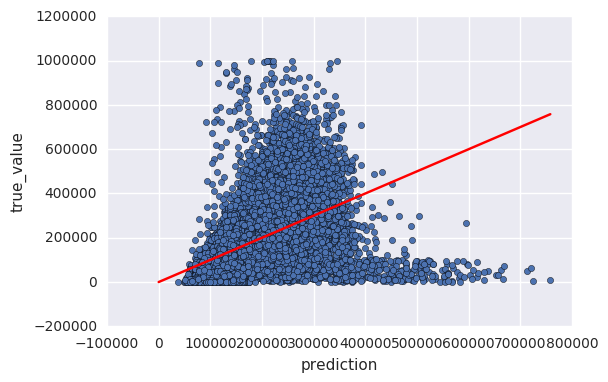

In [13]:
# Plot the prediction vs. true values
plotDf = pd.DataFrame({'prediction': enet.predict(X), 'true_value': target})
plotDf['residual'] = plotDf.true_value-plotDf.prediction
zz = np.array([0, plotDf.prediction.max()])
#fig, axes = plt.subplots()
plotDf.plot.scatter(x='prediction', y='true_value')
plt.plot(zz, zz, 'r-')
plt.show()

(-400000.0, 400000.0)

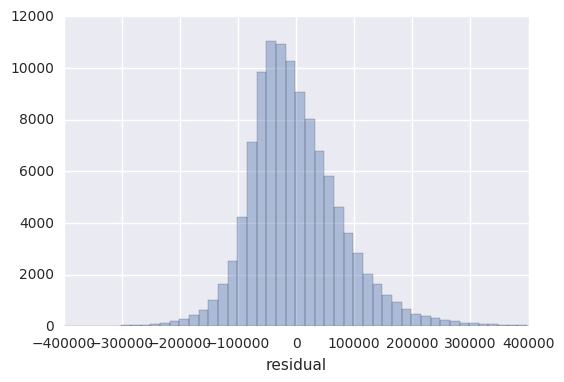

In [19]:
sns.distplot(plotDf.residual, bins=100, kde=False)
plt.xlim(-4e5,4e5)

In [20]:
l1s = (1-np.logspace(0,-2,num=5))
enetCV = ElasticNetCV(l1_ratio=l1s, alphas=np.logspace(-4,4,num=10), max_iter=5000)
enetCV.fit(X, target)

# print results
print(enetCV.alphas_)
print(enetCV.alpha_)
print(enetCV.l1_ratio_)
pd.Series(enetCV.coef_, index=X.columns)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:450: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


[  1.00000000e+04   1.29154967e+03   1.66810054e+02   2.15443469e+01
   2.78255940e+00   3.59381366e-01   4.64158883e-02   5.99484250e-03
   7.74263683e-04   1.00000000e-04]
0.00599484250319
0.9


omamassa                                            19144.825210
iskutilavuus                                         3893.556396
suurinNettoteho                                       659.050715
kayttoonottoVuosi                                   -6654.052709
ensirekVuosi                                       -36194.897400
usageDays                                           22201.629918
ajoneuvonkaytto_Kouluajoneuvo                      -15780.622892
ajoneuvonkaytto_Luvanvarainen                       38496.020141
ajoneuvonkaytto_Myyntivarasto                       -2070.953203
ajoneuvonkaytto_NA                                   1490.293507
ajoneuvonkaytto_Vuokraus                           -11013.539992
ajoneuvonkaytto_Yksityinen                         -11103.196058
ajoneuvoryhma_Alaluokka III (N1)                     2103.804763
ajoneuvoryhma_Esteetön taksiauto                    24154.003752
ajoneuvoryhma_Huoltoauto                            -8184.295570
ajoneuvoryhma_Invataksi  

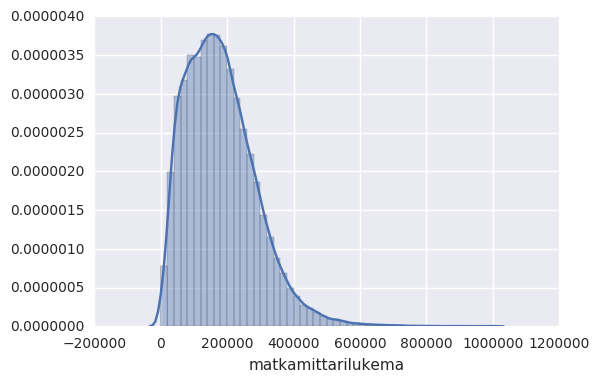

In [21]:
sns.distplot(target)

In [22]:
aa = pd.DataFrame(enetCV.mse_path_.mean(axis=2), index=l1s, columns=enetCV.alphas_)

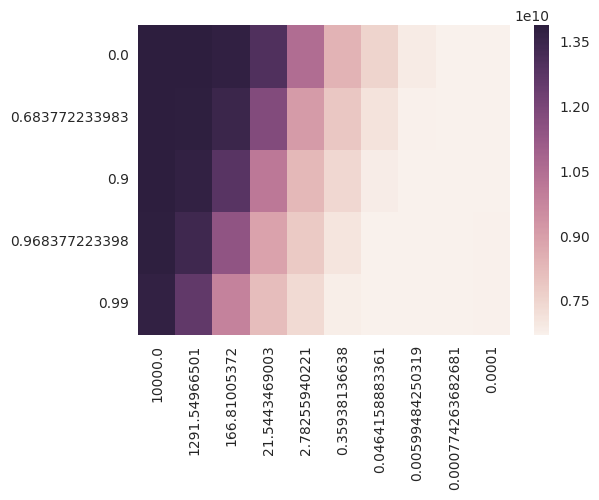

In [23]:
sns.heatmap(aa)

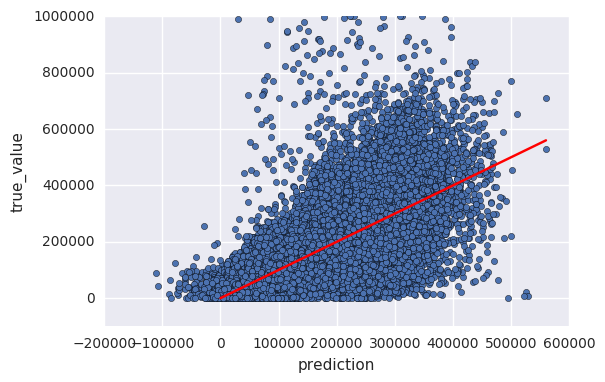

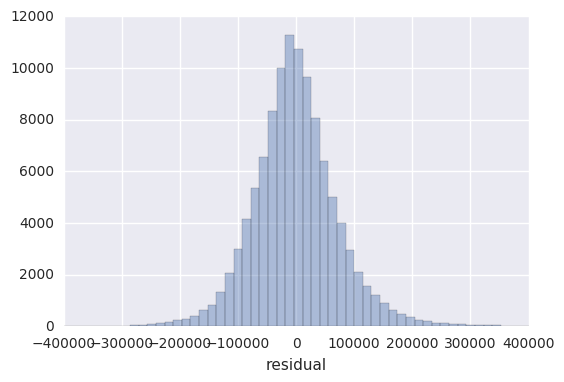

In [25]:
# Plot the prediction vs. true values
plotDf = pd.DataFrame({'prediction': enetCV.predict(X), 'true_value': target})
plotDf['residual'] = plotDf.true_value-plotDf.prediction
zz = np.array([0, plotDf.prediction.max()])
#fig, axes = plt.subplots()
plotDf.plot.scatter(x='prediction', y='true_value')
plt.plot(zz, zz, 'r-')
plt.ylim(-1e5,1e6)
plt.show()
sns.distplot(plotDf.residual, bins=100, kde=False)
plt.xlim(-4e5,4e5)
plt.show()

### Gradient boosting

In [26]:
gbr = ensemble.GradientBoostingRegressor(
    n_estimators=200,
    max_depth=3,
    min_samples_split=5,
    learning_rate=0.02,
    loss='ls',
    verbose=1
)

In [27]:
gbr.fit(X, target)

      Iter       Train Loss   Remaining Time 
         1 11353491614.7327           18.01s
         2 11155493456.5695           17.14s
         3 10963044108.9651           17.97s
         4 10780687931.8967           17.86s
         5 10602628711.5247           17.76s
         6 10431236620.5956           17.93s
         7 10268629507.0440           17.79s
         8 10110424407.9434           17.54s
         9  9957449840.8256           17.61s
        10  9810411748.6625           17.78s
        20  8590333274.0915           18.90s
        30  7717455245.5332           18.07s
        40  7104496919.0087           17.89s
        50  6654895307.4311           17.27s
        60  6337042902.3991           16.94s
        70  6097908509.4714           15.93s
        80  5916263335.5104           14.49s
        90  5773292494.1894           13.12s
       100  5657613598.9443           11.82s
       200  5135269792.5000            0.00s


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=1,
             warm_start=False)

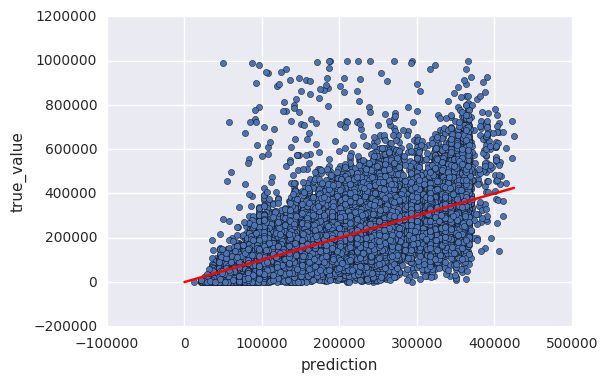

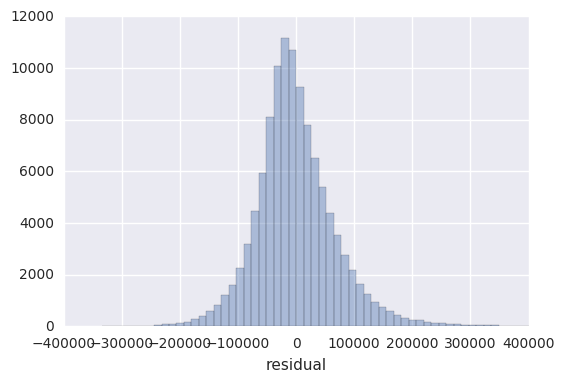

In [29]:
# Plot the prediction vs. true values
plotDf = pd.DataFrame({'prediction': gbr.predict(X), 'true_value': target})
plotDf['residual'] = plotDf.true_value-plotDf.prediction
zz = np.array([0, plotDf.prediction.max()])
#fig, axes = plt.subplots()
plotDf.plot.scatter(x='prediction', y='true_value')
plt.plot(zz, zz, 'r-')
plt.show()
sns.distplot(plotDf.residual, bins=100, kde=False)
plt.xlim(-4e5,4e5)
plt.show()

In [ ]:
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

In [ ]:
featDf=pd.Series(data=feature_importance, index=X.columns)
featDf.plot(kind='barh', figsize=(7, 15))

In [ ]:
usagedays = np.linspace(0, 5000, 100)

In [ ]:
tmp = pd.DataFrame(np.nan, index=np.ndarray(100), columns=X.columns)

In [ ]:
tmp.usageDays = np.linspace(0, 5000, 100)

In [ ]:
tmp.head()

### Save the fitted model and other relevant data

In [ ]:
pickle.dump(
    {
        'model': enet, 
        'scaler': scaler, 
        'imputer': imputer, 
        'trainColumns': X.columns,
        'factorVars': factorVars,
        'numericVars': numericVars,
        'dateVars': dateVars
    }, 
    open('enet.pyobj','wb')
)

In [ ]:
sns.countplot?